In [2]:
!pip install -U ultralytics umap-learn


  Using cached ultralytics-8.3.239-py3-none-any.whl.metadata (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 100.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9

## 1. Import

In [3]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET
import shutil, yaml, math, gc, contextlib
from pathlib import Path
from PIL import Image
import os

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm.auto import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", message="can only test a child process")

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [4]:
import torch.utils.data.dataloader as dataloader

# Monkey-patch to silence "can only test a child process" error
def patched_del(self):
    try:
        self._shutdown_workers()
    except Exception:
        pass

dataloader._MultiProcessingDataLoaderIter.__del__ = patched_del


In [5]:

BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_ssl_vit")
SPLIT = WORK / "0_yolo_split"
SSL_W = WORK / "dinov2_backbone.pth"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)


import random

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            # Convert to YOLO format
            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    # Wipe any old split to avoid stale empty folders
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    # Collect all image + xml pairs (support many extensions)
    all_pairs = []
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    for ext in exts:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))
    print(f"Found {len(all_pairs)} annotated images total.")

    if len(all_pairs) == 0:
        raise RuntimeError("❌ No image/xml pairs found. Check dataset path & extensions.")

    # Split into train/val/test
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "valid":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in your dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready.")


➤ Converting Pascal VOC → YOLO with auto split …
Found 23678 annotated images total.
train: 16574 images
valid: 4735 images
test: 2369 images
✓ YOLO split ready.


## 2. Augmentation

In [6]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

## 3. YOLO V12s model backbone in dino-v2

In [7]:
#import YOLO.

from ultralytics import YOLO
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [8]:
detector = YOLO("yolo12s.pt")   
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo12s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


## 4.projection head and loss function

In [9]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


## 5. training loop with hyperparameter and optimizer

In [10]:
from pathlib import Path


In [11]:
import math, gc
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm


In [12]:
# =========================
# Check if MultiCropDINO can be imported
# =========================
import importlib.util

modules_to_check = ["dino_utils", "dataset"]

found = False
for mod in modules_to_check:
    if importlib.util.find_spec(mod) is not None:
        try:
            exec(f"from {mod} import MultiCropDINO")
            print(f"✓ MultiCropDINO successfully imported from '{mod}'")
            found = True
            break
        except ImportError:
            pass

if not found:
    print("✗ MultiCropDINO not found in the usual modules. You need to define it manually.")


✗ MultiCropDINO not found in the usual modules. You need to define it manually.


In [13]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import random
import os

class MultiCropDINO(Dataset):
    def __init__(self, folders, g_size=224, l_size=96, n_local=8):
        self.paths = []
        for folder in folders:
            if os.path.exists(folder):
                self.paths += [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith((".jpg",".png"))]
        self.n_local = n_local
        self.global_transform = transforms.Compose([
            transforms.Resize((g_size, g_size)),
            transforms.ToTensor()
        ])
        self.local_transform = transforms.Compose([
            transforms.Resize((l_size, l_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        crops = [self.global_transform(img), self.global_transform(img)]
        for _ in range(self.n_local):
            crops.append(self.local_transform(img))
        return crops


In [15]:
#With 2 GPUs, Batch size= 16

# ========================
# Imports
# ========================
import math
import gc
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ========================
# Hyperparameters
# ========================
EPOCHS     = 25      
BATCH      = 16
ACCUM      = 6
LR         = 1e-4
WD         = 0.05
EMA0       = 0.999
N_LOCAL    = 8
NUM_WORKERS= 2

# ========================
# Dataset paths
# ========================
WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
SSL_W = WORK / "ssl_yolov12s_backbone.pt"

# ========================
# Check for existing backbone
# ========================
if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\nDINOv2-style pretraining on YOLOv12s backbone …")

    # ========================
    # Dataset and DataLoader
    # ========================
    ds = MultiCropDINO([WORK/"train/images", WORK/"valid/images", WORK/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    # ========================
    # Device and Multi-GPU Setup
    # ========================
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_gpu = torch.cuda.device_count()
    print(f"Detected {n_gpu} GPU(s).")

    # Wrap models with DataParallel if more than 1 GPU
    if n_gpu > 1:
        student_enc = nn.DataParallel(student_enc)
        student_head = nn.DataParallel(student_head)
        teacher_enc = nn.DataParallel(teacher_enc)
        teacher_head = nn.DataParallel(teacher_head)

    student_enc.to(device)
    student_head.to(device)
    teacher_enc.to(device)
    teacher_head.to(device)

    # ========================
    # Optimizer, Scheduler, Loss
    # ========================
    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    # ========================
    # Training Loop
    # ========================
    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train()
    student_head.train()

    for ep in range(EPOCHS):
        ep_loss = 0.0
        accum = 0
        opt.zero_grad(set_to_none=True)

        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]

            with torch.amp.autocast(device_type="cuda" if device=="cuda" else "cpu"):
                # Student forward pass
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]

                # Teacher forward pass (no grad)
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]  # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]

                # Compute DINO loss
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            accum += 1

            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (handle DataParallel)
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    student_bb_params = student_enc.module.bb.parameters() if n_gpu > 1 else student_enc.bb.parameters()
                    teacher_bb_params = teacher_enc.module.bb.parameters() if n_gpu > 1 else teacher_enc.bb.parameters()
                    for ps, pt in zip(student_bb_params, teacher_bb_params):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)

                    student_head_params = student_head.module.parameters() if n_gpu > 1 else student_head.parameters()
                    teacher_head_params = teacher_head.module.parameters() if n_gpu > 1 else teacher_head.parameters()
                    for ps, pt in zip(student_head_params, teacher_head_params):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)

                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    # ========================
    # Save pretrained backbone
    # ========================
    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    student_bb_to_save = student_enc.module.bb if n_gpu > 1 else student_enc.bb
    torch.save(student_bb_to_save.state_dict(), SSL_W)

    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv12s backbone →", SSL_W)
    print("✓ DINOv2-style pretraining complete.\n")



DINOv2-style pretraining on YOLOv12s backbone …
Detected 2 GPU(s).


SSL Epoch 01: loss=1.1483


SSL Epoch 02: loss=1.0668


SSL Epoch 03: loss=1.0669


SSL Epoch 04: loss=1.0546


SSL Epoch 05: loss=0.9949


SSL Epoch 06: loss=0.9515


SSL Epoch 07: loss=0.9183


SSL Epoch 08: loss=0.8853


SSL Epoch 09: loss=0.8651


SSL Epoch 10: loss=0.8347


SSL Epoch 11: loss=0.8325


SSL Epoch 12: loss=0.8089


SSL Epoch 13: loss=0.8037


SSL Epoch 14: loss=0.7931


SSL Epoch 15: loss=0.7803


SSL Epoch 16: loss=0.7732


SSL Epoch 17: loss=0.7586


SSL Epoch 18: loss=0.7621


SSL Epoch 19: loss=0.7616


SSL Epoch 20: loss=0.7631


SSL Epoch 21: loss=0.7677


SSL Epoch 22: loss=0.7776


SSL Epoch 23: loss=0.7972


SSL Epoch 24: loss=0.8074


SSL Epoch 25: loss=0.8383
✓ Saved SSL YOLOv12s backbone → /kaggle/working/traffic_ssl_vit/0_yolo_split/ssl_yolov12s_backbone.pt
✓ DINOv2-style pretraining complete.



## 6. Fine-Tuning with SSL Backbone

In [16]:
# ========================
# Fine-tuning YOLOv12s with SSL Backbone
# ========================

# Use your newly pretrained SSL backbone
SSL_W = "/kaggle/working/traffic_ssl_vit/0_yolo_split/ssl_yolov12s_backbone.pt"

# Initialize fresh YOLOv12s model
det = YOLO("yolo12s.pt")

# Detect available GPUs
device = "cuda" if torch.cuda.is_available() else "cpu"
n_gpu = torch.cuda.device_count()
print(f"Detected {n_gpu} GPU(s).")

# Load the SSL pretrained backbone directly on GPU
backbone_state = torch.load(SSL_W, map_location=device)
missing, unexpected = det.model.model[0].load_state_dict(backbone_state, strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

# Fine-tune / train on labeled dataset
det.train(
    data=str(DATA),            # path to your dataset YAML
    epochs=25,
    imgsz=640,
    batch=16,                  # total batch size (will be split across GPUs automatically)
    save=True,
    save_period=1,
    project=str(WORK),
    name="ssl_yolov12s_dinov2",
    device="0,1" if n_gpu > 1 else 0  # use both GPUs if available
)


Detected 2 GPU(s).
Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_ssl_vit/data_traffic.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosai

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46253      0.661      0.711      0.732      0.499
              Rickshaw       3886      11929      0.761       0.86      0.895      0.618
                   Bus       3880      10302      0.773      0.849       0.89      0.644
                 Truck        269        292      0.402      0.507      0.456      0.341
                  Bike       2140       3183      0.716      0.822       0.84      0.509
                People       2960       7814      0.739      0.809      0.856      0.543
                   Car       4294      12579      0.807      0.895      0.933      0.697
                 Cycle        149        154      0.426      0.234      0.254      0.141
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/traffic_ssl_vit/0_yolo_split/ssl_yolov12s_dinov2


## 7. Loss Curve Visualization

Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


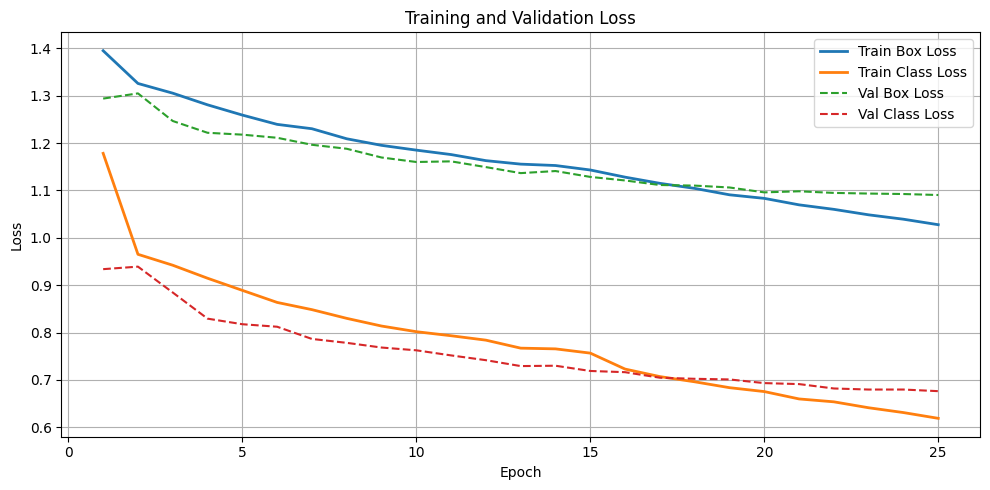

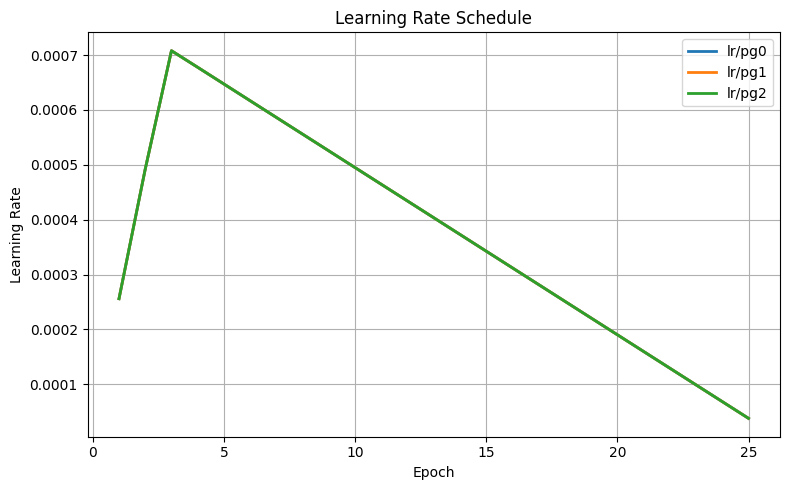

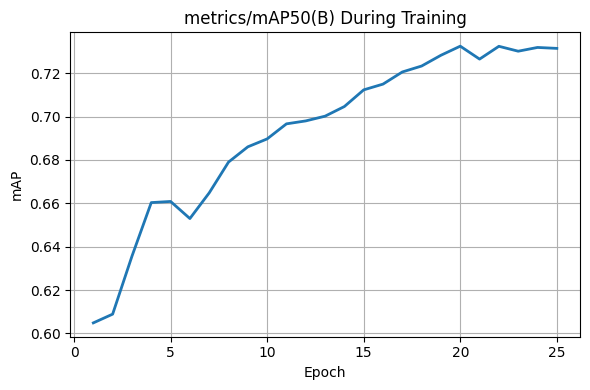

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Base experiment directory
WORK2 = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")

# Path to YOLO results.csv
results_path = WORK2 / "ssl_yolov12s_dinov2" / "results.csv"

# Load results
df = pd.read_csv(results_path)

# Inspect columns (important for compatibility across YOLO versions)
print("Available columns:")
print(df.columns.tolist())

# =========================
# Plot Training & Validation Loss
# =========================
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# Plot Learning Rate Schedules
# =========================
lr_columns = [c for c in df.columns if c.startswith("lr/pg")]

if lr_columns:
    plt.figure(figsize=(8, 5))
    for col in lr_columns:
        plt.plot(df["epoch"], df[col], label=col, linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")

# =========================
# Plot mAP Curves
# =========================
map_candidates = [
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/mAP50",
    "metrics/mAP50-95"
]

map_column = next((c for c in map_candidates if c in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title(f"{map_column} During Training")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


In [18]:
lr_columns = [c for c in df.columns if c.startswith("lr/pg")]
print(lr_columns)


['lr/pg0', 'lr/pg1', 'lr/pg2']


Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


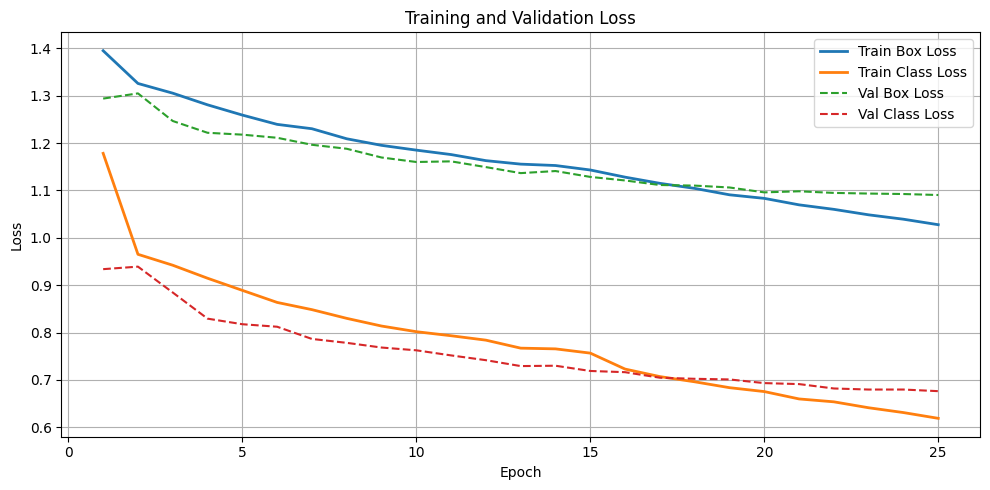

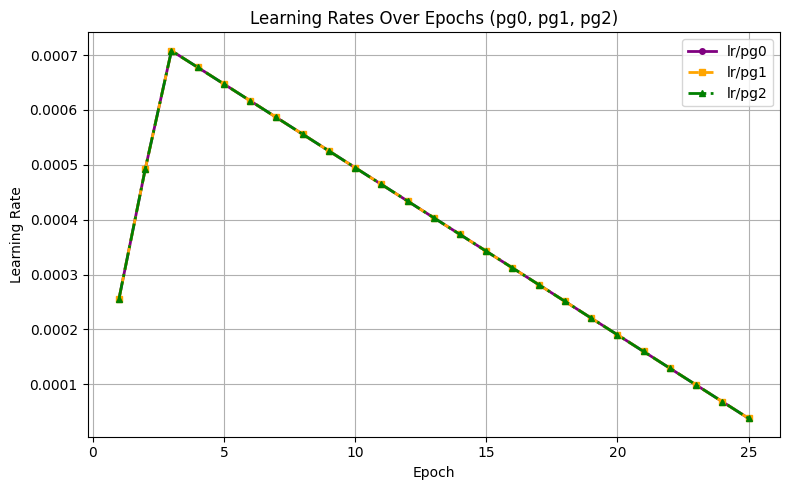

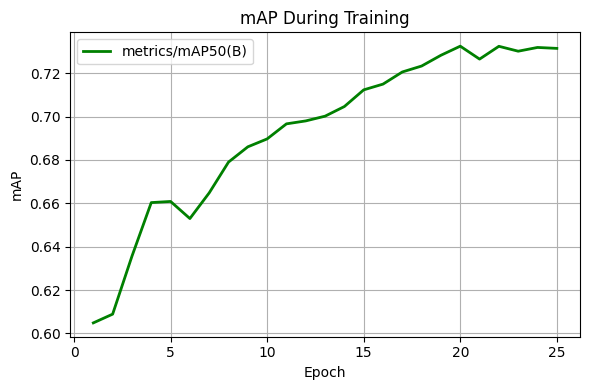

In [19]:
#with three lr ['lr/pg0', 'lr/pg1', 'lr/pg2']

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Base experiment directory
WORK2 = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split") 

# Path to results.csv
results_path = WORK2 / "ssl_yolov12s_dinov2" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# =========================
# Plot Loss Curves
# =========================
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# Plot Learning Rate Schedules
# =========================
lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")

# =========================
# Plot mAP Curves
# =========================
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


## 8. Detection

Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1632.9±260.7 MB/s, size: 64.9 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 12 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 8.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 17.7it/s 1:07<0.1ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46253      0.661      0.711      0.732        0.5
              Rickshaw       3886      11929      0.761       0.86      0.895      0.618
                   Bus       3880      10302      0.772       0.85       0.89      0.645
                 Truck        269        292      0.401      0.507      0.456      0.341
                  Bike       2140       3183      0.716      0.822       0.84      0.512
                People       2960       7814      0.739      0.809      0.856      0.542
                   Car       4294      12579      0.807      0.895      0.933      0.697
                 Cycle        149        154       0.43      0.234      0.254      0.142
Speed: 0.7ms preprocess, 9.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

Validation metrics
 Precision (mP) : 0.6608
 Recall    (mR) : 0.7110
 mAP@0.50      : 0.7320
 mAP@0.50-0.95 : 0.4996


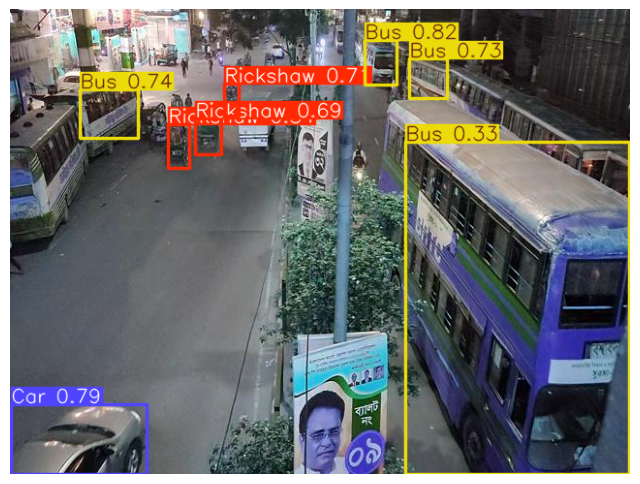

In [20]:
import torch, random
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device_int = 0 if device=="cuda" else "cpu"

WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
best_pt = WORK / "ssl_yolov12s_dinov2" / "weights" / "best.pt"

model_det = YOLO(str(best_pt))

# Validate
results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=device_int)

try:
    mp, mr, map50, map5095 = results.mean_results()
except AttributeError:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# Visualize a random test image
test_imgs = list((WORK/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=device_int,
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot())  # RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")


Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1782.6±522.3 MB/s, size: 71.8 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 12 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 8.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 17.6it/s 1:07<0.1ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46253      0.661      0.711      0.732        0.5
              Rickshaw       3886      11929      0.761       0.86      0.895      0.618
                   Bus       3880      10302      0.772       0.85       0.89      0.645
                 Truck        269        292      0.401      0.507      0.456      0.341
                  Bike       2140       3183      0.716      0.822       0.84      0.512
                People       2960       7814      0.739      0.809      0.856      0.542
                   Car       4294      12579      0.807      0.895      0.933      0.697
                 Cycle        149        154       0.43      0.234      0.254      0.142
Speed: 0.7ms preprocess, 9.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2

Validation metrics
 Precision (mP) : 0.6608
 Recall    (mR) : 0.7110
 mAP@0.50      : 0.7320
 mAP@0.50-0.95 : 0.4996


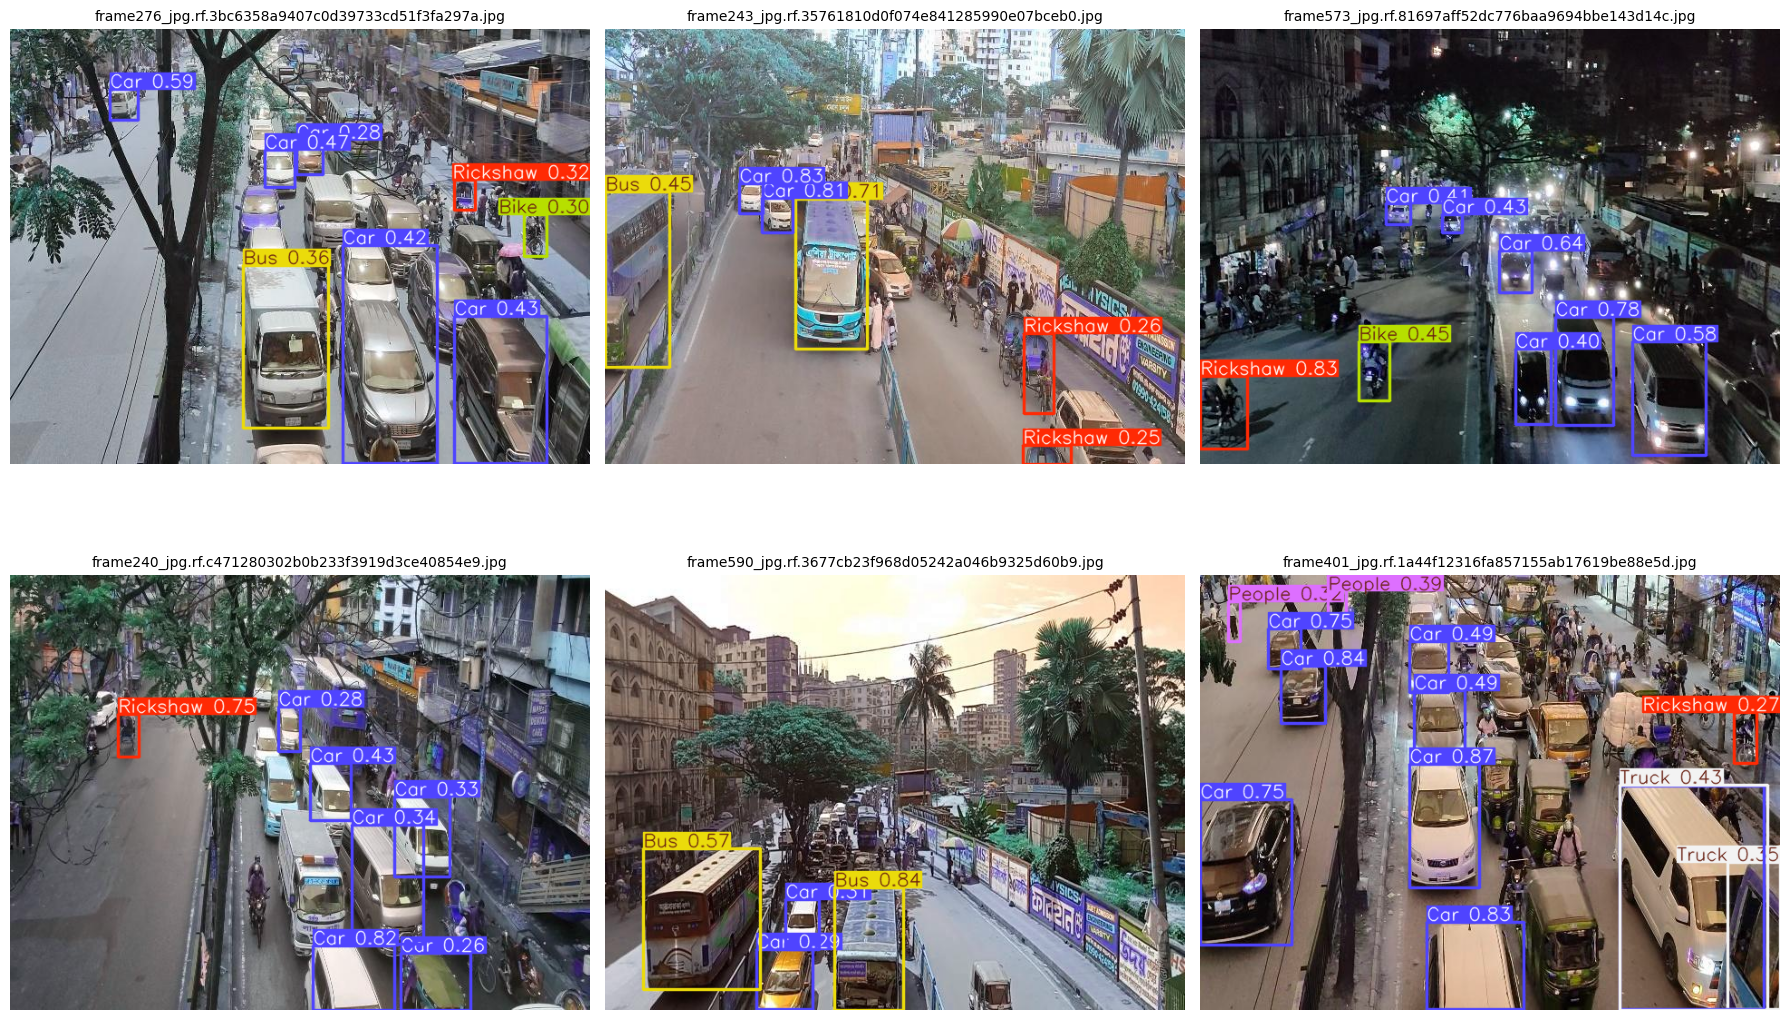

In [21]:
#Multiple

import torch, random
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device_int = 0 if device=="cuda" else "cpu"

WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
best_pt = WORK / "ssl_yolov12s_dinov2" / "weights" / "best.pt"

model_det = YOLO(str(best_pt))

# Validate model
results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=device_int)

try:
    mp, mr, map50, map5095 = results.mean_results()
except AttributeError:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# Visualize multiple random test images
test_imgs = list((WORK/"test/images").glob("*.*"))
n_images = 6  # Number of images to display

if test_imgs:
    sample_imgs = random.sample(test_imgs, min(n_images, len(test_imgs)))
    n_cols = 3
    n_rows = (len(sample_imgs) + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols*6, n_rows*6))
    
    for idx, img_path in enumerate(sample_imgs, 1):
        pred = model_det.predict(source=str(img_path),
                                 imgsz=640,
                                 conf=0.25,
                                 device=device_int,
                                 verbose=False)[0]
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(pred.plot())  # RGB
        plt.title(f"{img_path.name}", fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No test images found for visualization.")


Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1909.1±590.3 MB/s, size: 72.7 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 12 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 8.0Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 17.6it/s 1:07<0.1ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46253      0.661      0.711      0.732        0.5
              Rickshaw       3886      11929      0.761       0.86      0.895      0.618
                   Bus       3880      10302      0.772       0.85       0.89      0.645
                 Truck        269        292      0.401      0.507      0.456      0.341
                  Bike       2140       3183      0.716      0.822       0.84      0.512
                People       2960       7814      0.739      0.809      0.856      0.542
                   Car       4294      12579      0.807      0.895      0.933      0.697
                 Cycle        149        154       0.43      0.234      0.254      0.142
Speed: 0.7ms preprocess, 9.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val3

Validation metrics
 Precision (mP) : 0.6608
 Recall    (mR) : 0.7110
 mAP@0.50      : 0.7320
 mAP@0.50-0.95 : 0.4996


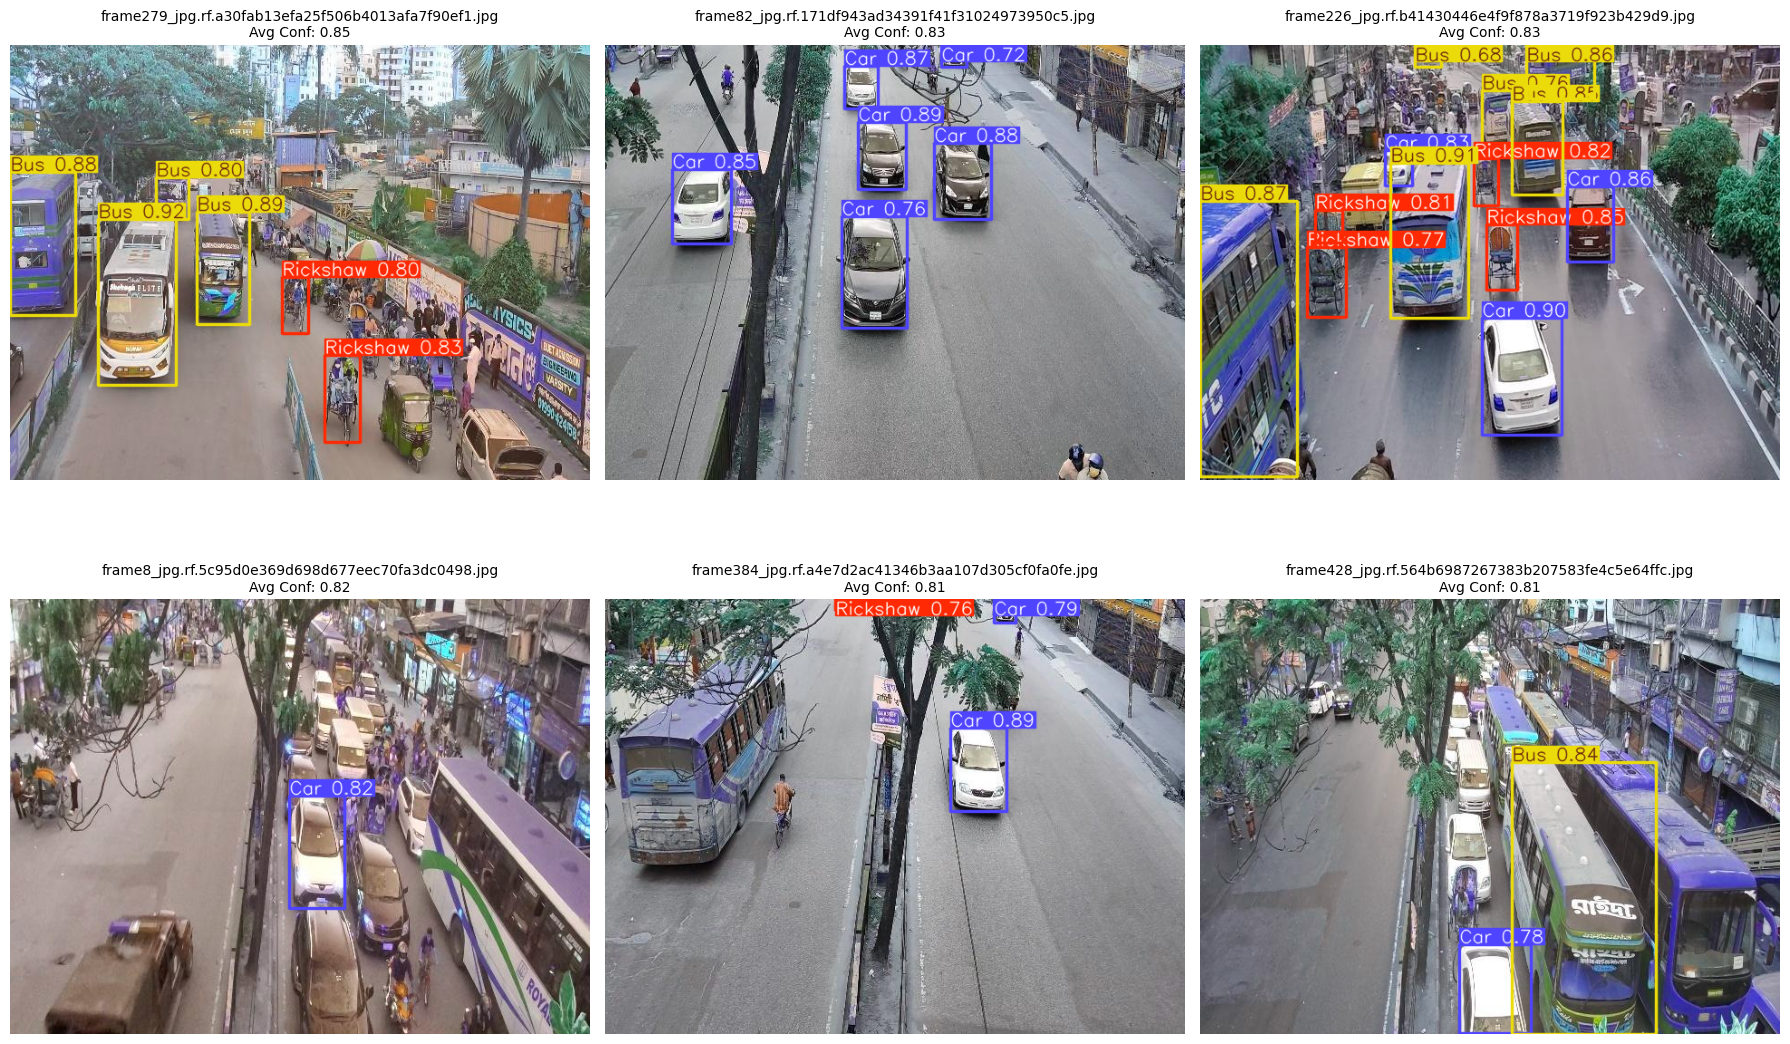

In [22]:
#visualize the top “best performed” test images
#based on the highest average confidence of predictions per image.

import torch, random
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device_int = 0 if device=="cuda" else "cpu"

WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
best_pt = WORK / "ssl_yolov12s_dinov2" / "weights" / "best.pt"

model_det = YOLO(str(best_pt))

# Validate model
results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=device_int)

try:
    mp, mr, map50, map5095 = results.mean_results()
except AttributeError:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# -----------------------------
# Visualize top-performing test images
# -----------------------------
test_imgs = list((WORK/"test/images").glob("*.*"))
n_images = 6  # number of top images to show

if test_imgs:
    img_conf_list = []
    
    # Predict on all test images and compute mean confidence
    for img_path in test_imgs:
        pred = model_det.predict(source=str(img_path),
                                 imgsz=640,
                                 conf=0.25,
                                 device=device_int,
                                 verbose=False)[0]
        # average confidence for all detected boxes in this image
        if pred.boxes is not None and len(pred.boxes) > 0:
            avg_conf = pred.boxes.conf.cpu().numpy().mean()
        else:
            avg_conf = 0
        img_conf_list.append((img_path, avg_conf, pred))
    
    # Sort images by descending avg confidence
    img_conf_list.sort(key=lambda x: x[1], reverse=True)
    
    top_imgs = img_conf_list[:min(n_images, len(img_conf_list))]
    
    n_cols = 3
    n_rows = (len(top_imgs) + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols*6, n_rows*6))
    
    for idx, (img_path, conf, pred) in enumerate(top_imgs, 1):
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(pred.plot())  # RGB
        plt.title(f"{img_path.name}\nAvg Conf: {conf:.2f}", fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No test images found for visualization.")


In [23]:
#Save 

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import zipfile

# =========================
# Set paths
# =========================
WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
EXPERIMENT_NAME = "ssl_yolov12s_dinov2"
EXPERIMENT = WORK / EXPERIMENT_NAME
OUTPUT_DIR = WORK / "final_output"
OUTPUT_DIR.mkdir(exist_ok=True)

# =========================
# Copy entire experiment folder
# =========================
shutil.copytree(EXPERIMENT, OUTPUT_DIR / EXPERIMENT_NAME, dirs_exist_ok=True)
print(f"Copied experiment folder to {OUTPUT_DIR}")

# =========================
# Load results.csv for plotting
# =========================
results_csv = EXPERIMENT / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
else:
    raise FileNotFoundError(f"{results_csv} not found!")

# =========================
# Save Loss Plot
# =========================
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "loss_plot.png")
plt.close()

# =========================
# Save Learning Rate Plot
# =========================
lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8,5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "lr_plot.png")
    plt.close()

# =========================
# Save mAP Plot
# =========================
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6,4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "map_plot.png")
    plt.close()

# =========================
# Zip everything
# =========================
zip_path = WORK / "traffic_experiment_output.zip"
shutil.make_archive(base_name=str(zip_path).replace(".zip",""), 
                    format='zip', 
                    root_dir=OUTPUT_DIR)

print(f"All outputs zipped at: {zip_path}")


Copied experiment folder to /kaggle/working/traffic_ssl_vit/0_yolo_split/final_output
All outputs zipped at: /kaggle/working/traffic_ssl_vit/0_yolo_split/traffic_experiment_output.zip


In [24]:
from pathlib import Path

# Path to the zip file
zip_path = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split/traffic_experiment_output.zip")

# Check if file exists
if zip_path.exists():
    print(f"The zip file exists at: {zip_path}")
else:
    print("Zip file not found!")


The zip file exists at: /kaggle/working/traffic_ssl_vit/0_yolo_split/traffic_experiment_output.zip
